# A Simple Example on Creating a Custom Refutation Using User-Defined Outcome Functions
In this experiment, we define a linear dataset. In order to find the coefficients, we make use of the linear regression estimator. In order to test the effectiveness of the linear estimator, we now replace the outcome value with a dummy produced with the help of a linear expression based on the value of the confounders. This effectively means that the effect of the treatment on the outcome should be zero. This is exactly, what we should expect from the results of the refuter.

## Insert Dependencies

In [1]:
from dowhy import CausalModel
import dowhy.datasets
import pandas as pd
import numpy as np

# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'WARN',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)

## Create the Dataset
You can change the values of the hyper params to see how the effects change, as each parameter changes
Variable Guide:

| Variable Name   | Data Type |  Interpretation    |
|-----------------|-----------|--------------------|
|   $Z_i$         |  float    | Insrument Variable |
|   $W_i$         |  float    | Confounder         |
|   $v_0$         |  float    | Treatment          |
|    $y$          |  float    | Outcome            |



In [2]:
# Value of the coefficient [BETA]
BETA = 10
# Number of Common Causes
NUM_COMMON_CAUSES = 2
# Number of Instruments
NUM_INSTRUMENTS = 1
# Number of Samples
NUM_SAMPLES = 100000
# Treatment is Binary
TREATMENT_IS_BINARY = True
data = dowhy.datasets.linear_dataset(beta=BETA,
                                 num_common_causes=NUM_COMMON_CAUSES,
                                 num_instruments=NUM_INSTRUMENTS,
                                 num_samples=NUM_SAMPLES,
                                 treatment_is_binary=TREATMENT_IS_BINARY)
data['df'].head()

,Z0,W0,W1,v0,y
0,0.0,0.372507,-0.817539,True,9.630655
1,0.0,0.054225,-0.353130,True,9.375290
2,0.0,-0.146477,0.690753,False,1.035762
3,0.0,-1.408927,-0.630200,False,-7.673632
4,0.0,1.266625,0.436630,False,6.600853


## Creating the Causal Model

In [3]:
model = CausalModel(
    data = data['df'],
    treatment = data['treatment_name'],
    outcome = data['outcome_name'],
    graph = data['gml_graph'],
    instruments = data['instrument_names']
)

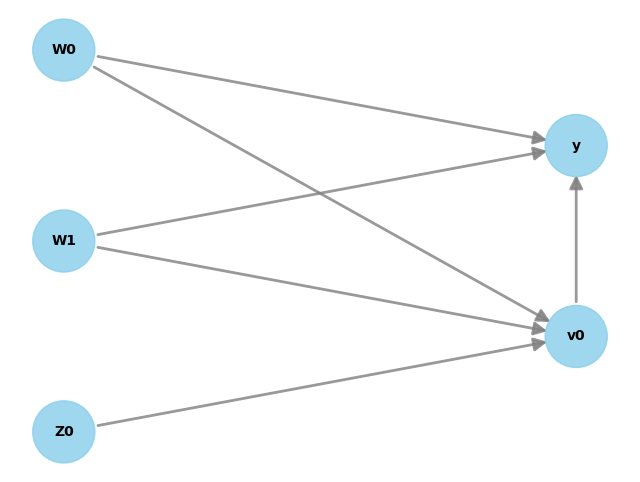

In [4]:
model.view_model()

In the above figure, we have a causal graph that shows the relationships between the treatment, outcome, confounders and the instrument variable.
- The Confounders $W_0$ and $W_1$ affect both the treatment and the outcome
- The instrument variable $Z_0$ is able to effect the outcome $y$ through the treatment $x$

## Identify the Estimand

In [5]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d              
─────(E[y|W0,W1])
d[v₀]            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,U) = P(y|v0,W0,W1)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                      -1⎤
 ⎢  d      ⎛  d        ⎞  ⎥
E⎢─────(y)⋅⎜─────([v₀])⎟  ⎥
 ⎣d[Z₀]    ⎝d[Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0})
Estimand assumption 2, Exclusion: If we remove {Z0}→{v0}, then ¬({Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Estimating the Effect

In [6]:
causal_estimate = model.estimate_effect( identified_estimand,
                                       method_name="iv.instrumental_variable",
                                       method_params={'iv_instrument_name':'Z0'}
                                       )
print(causal_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                      -1⎤
 ⎢  d      ⎛  d        ⎞  ⎥
E⎢─────(y)⋅⎜─────([v₀])⎟  ⎥
 ⎣d[Z₀]    ⎝d[Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0})
Estimand assumption 2, Exclusion: If we remove {Z0}→{v0}, then ¬({Z0}→y)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
 ⎡ d    ⎤ 
E⎢───(y)⎥ 
 ⎣dZ₀   ⎦ 
──────────
 ⎡ d     ⎤
E⎢───(v₀)⎥
 ⎣dZ₀    ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0})
Estimand assumption 2, Exclusion: If we remove {Z0}→{v0}, then ¬({Z0}→y)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['v0'] is affected in the same way by common causes of ['v0'] and ['y']
Estimand assumption 4, outcome_effect_homogeneity: Each unit's outcome ['y'] is affected in the same way by com

## Refuting the Estimate

## Using a Randomly Generated Outcome

In [7]:
ref = model.refute_estimate(identified_estimand,
                           causal_estimate,
                           method_name="dummy_outcome_refuter"
                           )
print(ref[0])

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:0.0007105193707385702
p value:1.0



The result shows that the treatment does not lead to the outcome. The estimated effect is a value that tends to zero, which matches our expectation. This shows that if we replace the outcome by randomly generated data, the estimator correctly predicts that the influence if treatment is Zero.

## Using a Function that Generates the Outcome from the Confounders

Let us define a simple function that generates the outcome as a linear function of the confounders.

In [8]:
coefficients = np.array([1,2])
bias = 3
def linear_gen(df):
    y_new = np.dot(df[['W0','W1']].values,coefficients) + 3
    return y_new

The basic expression is of the form
$y_{new} = \beta_0W_0 + \beta_1W_1 + \gamma_0$

where,
$\beta_0=1$, $\beta_1=2$ and $\gamma_0=3$

In [9]:
ref = model.refute_estimate(identified_estimand,
                           causal_estimate,
                           method_name="dummy_outcome_refuter",
                           outcome_function=linear_gen
                           )

print(ref[0])

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:0.000579305362263616
p value:0.9199999999999999



Like the previous experiment, we observe that the estimator shows that the effect of the treatment is Zero. The refuter confirms this as the value obtained through the refutation is quite low and has a p value of >0.05 across 100 simulations.